In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
# Start with a SQL query to the SDSS database to get the data

from astroquery.sdss import SDSS
zmin=0.015
zmax=0.05
sql=' SELECT \
      objid,ra,dec,petroMag_g,petroMag_r, \
      extinction_g,extinction_r,z,class \
      FROM SpecPhotoAll \
    WHERE \
      z > {:f} AND z < {:f} AND class = "GALAXY" \
      AND (ra between 140 and 240) and (dec between 0 and 50)'.format(zmin,zmax)
dr18=SDSS.query_sql(sql, data_release=18)

print(dr18) # Inspect the data

       objid            ra        dec     ... extinction_r     z      class 
------------------- --------- ----------- ... ------------ ---------- ------
1237648722295914556 160.47247   0.7931804 ...    0.1251861 0.01879655 GALAXY
1237648721759174849 160.81279  0.22058811 ...    0.1273071 0.04696816 GALAXY
1237654671350890705 160.70018  0.91323393 ...    0.1143201 0.03991608 GALAXY
1237674650457866486 162.46552  0.16418646 ...   0.09292713 0.03951909 GALAXY
1237674650457801084 162.19973   0.1683697 ...   0.09207966 0.03898765 GALAXY
1237654670277738693 162.03127  0.16711747 ...   0.08996091 0.03935543 GALAXY
1237654670277607654 161.74289  0.17594243 ...   0.09041648 0.04922131 GALAXY
1237654670277476668 161.49685 0.011219673 ...   0.09685297 0.03825257 GALAXY
1237654670277541948   161.562 0.050263446 ...   0.09299849 0.04655844 GALAXY
1237654670277542363 161.64318    0.170166 ...   0.09128486 0.04030792 GALAXY
                ...       ...         ... ...          ...        ...    ...

In [3]:
# Determine distances (in Mpc) from Hubble law

c=3.e5  # km/s
h0=70   # km/s/Mpc
dist=dr18['z']*c/h0  # distance in Mpc

Below, we calculate the absolute magnitude of galaxies in the r-band, $M_r$, using the Petrosian magnitude and extinction corrections. The absolute magnitude is a measure of the intrinsic brightness of an object, unaffected by distance or other factors. It provides a standardised way to compare the luminosities of galaxies, stars, and other astronomical objects. The extinction corrections account for the dimming of light due to dust and other factors in the interstellar medium. By applying these corrections, we can obtain a more accurate representation of the true luminosity of galaxies in the r-band. Some definitions to keep in mind:
 
- Petrosian magnitude or ([petroMag](https://skyserver.sdss.org/dr7/en/help/docs/algorithm.asp?key=mag_petro)), which is the apparent magnitude that is observed from the Earth. It represents the brightness of an object as seen from our location without any corrections.

- Extinction Corrections or ([extinction](https://skyserver.sdss.org/dr7/en/help/docs/algorithm.asp#E), which is a term that accounts for the extinction of light due to interstellar dust and other factors. Extinction causes the observed magnitude to be fainter than the intrinsic magnitude of the object.

Below, we are subtracting the extinction, effectively converting the apparent magnitude to an unextincted apparent magnitude.

In [4]:
# in Mpc, m-M = 5 log d + 25
r=dr18['petroMag_r']-dr18['extinction_r']-5*np.log10(dist)-25

Let's plot an r-band luminosity function, but keep in mind it is uncorrected at this stage...


Text(0, 0.5, 'Number of galaxies (uncorrected)')

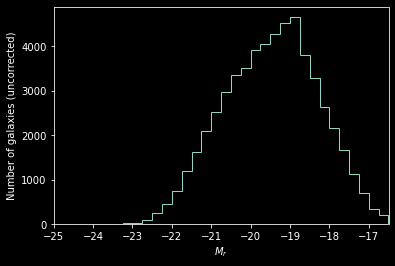

In [5]:
plt.style.use('dark_background')
out=plt.hist(r,bins=np.arange(-25,-16.3,0.25),histtype='step')
plt.xlim(-25,-16.5)
plt.xlabel('$M_r$')
plt.ylabel('Number of galaxies (uncorrected)')

When plotting a histogram of galaxy magnitudes without correction, you represent the observed distribution, which is skewed towards brighter galaxies. This bias occurs because a galaxy’s apparent magnitude is inversely affected by its distance $-$ the farther away a galaxy is, the dimmer it appears. As a result, distant low-luminosity galaxies are underrepresented. To correct for this, the 1/Vmax method accounts for the varying volumes within which galaxies can be observed. It calculates the maximum observable volume (Vmax) for each galaxy and uses this as a weight to adjust the histogram, providing a more accurate representation of the intrinsic luminosity function. This correction is essential for understanding the true distribution of galaxy properties and comparing different datasets and models. Read more [here](http://lifeng.lamost.org/courses/astr553/Topic04/Lecture_4.html)

 

In [6]:
# center our histogram bins into mabs
mabs=out[1][0:-1]+0.05
# apparent magnitude limit of SDSS
mlim=17.77 
# use the mlim and mabs to determine the maximum distance
dmax=10**((mlim-mabs-25)/5)
# set a maximum distance of zmax=0.05 (based on our SQL selection criteria)
dmax[dmax>zmax*c/h0] = zmax*c/h0
# sets a minimum distance of zmin=0.015 (based on our SQL selection criteria)
dmin=.015*3.e5/70
print(dmin,mlim-5*np.log10(dmin)-25)
# volume probed as a function of mabs
vol = (dmax**3-dmin**3)

64.28571428571429 -16.270572368805432


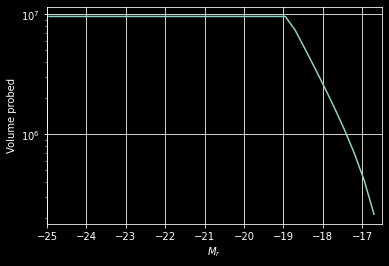

In [7]:
# Plot the volume probed as a function of mabs
plt.plot(mabs,vol)
plt.xlim(-25,-16.5)
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('Volume probed')
plt.grid()

We then use this volume to correct our histogram of galaxies by absolute magnitude.

Text(0, 0.5, '$\\phi$')

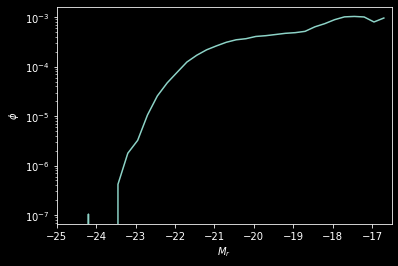

In [8]:
# corrected luminosity function
lf=out[0]/vol
plt.plot(mabs,lf)
plt.xlim(-25,-16.5)
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi$')

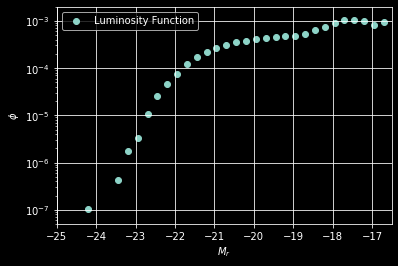

In [9]:
# create a scatter plot of the luminosity function
plt.scatter(mabs, lf, label='Luminosity Function')
plt.xlim(-25, -16.5)
plt.ylim(5e-8, 2e-3) 
plt.yscale('log')
plt.xlabel('$M_r$')
plt.ylabel('$\phi$')
plt.grid(True)
plt.legend()
plt.show()

Pause here. Perhaps you want to export the data for analysis elsewhere? You can do this by copying the data to the clipboard using the below.

In [10]:
data_dict = {'Absolute Magnitude (M_r)': mabs, 'Weighted Counts': lf}
df = pd.DataFrame(data_dict)
# Copy the DataFrame to the clipboard
df.to_clipboard(index=False, header=True)

To gain a better understanding of the distribution of galaxy magnitudes (or luminosities) in the universe, we can fit a Schechter function to the corrected luminosity function. The Schechter function models the number of galaxies per unit magnitude,  $\phi(M) dM$ , and is widely used for this purpose. It includes three key parameters:  $\phi^*$  (the characteristic density),  $\alpha$  (the faint-end slope), and  $M^*$  (the characteristic magnitude). These parameters allow us to describe the intrinsic properties of galaxy populations, including the distribution of magnitudes and the types of galaxies present.

Fitting the Schechter function involves adjusting these parameters to best match the observed data. This process helps estimate the characteristic values that describe the luminosity distribution in the surveyed region of the universe. For further details, please review the provided [PDF and recording](https://canvas.qut.edu.au/courses/13966/pages/luminosity-functions?module_item_id=1472015) (QARG Students only).

We now calculate and visualise a Schechter function fit to our luminosity function represented in magnitudes, both with and without data point filtering based on the Mabs value.

Schechter fit:
Mstar: -21.666267 
 alpha: -1.250501 
  phistar: 0.000338


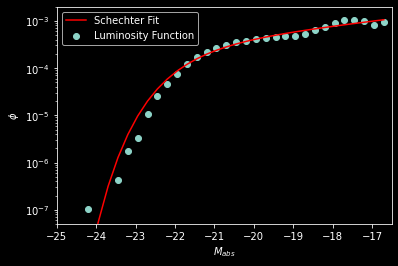

In [13]:
# Define the Schechter function
def schechter(m,mstar=-21,alpha=-1,phistar=1) :
    return phistar*10.**(-0.4*(alpha+1)*(m-mstar))*np.exp(-10.**(-0.4*(m-mstar)))
    
# Plot the corrected LF
plt.scatter(mabs, lf, label='Luminosity Function')
plt.xlim(-25, -16.5)
plt.ylim(5e-8, 2e-3)
plt.yscale('log')

# Do the fit with curve_fit
p0 = [-21, -1, 1]   # Starting guess for fit
from scipy.optimize import curve_fit
pars = curve_fit(schechter, mabs, lf, p0=p0)
print('Schechter fit:')
print('Mstar: {:f} \n alpha: {:f} \n  phistar: {:f}'.format(*pars[0]))

# Plot the Schechter fit
plt.plot(mabs, schechter(mabs, *pars[0]), 'r', label='Schechter Fit')
plt.xlabel('$M_{abs}$')
plt.ylabel('$\phi$')
plt.legend()
plt.show()

Schechter fit after removing brightest bins:
Mstar: -21.666280 
 alpha: -1.250502 
  phistar: 0.000338


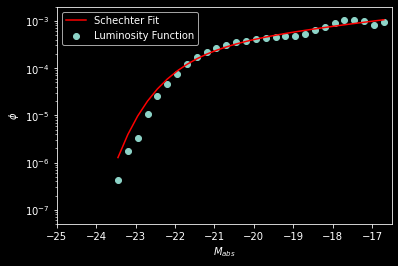

In [14]:
# Try again, removing data with Mabs < -23.5
plt.figure()
gd = np.where(mabs > -23.5)[0]
pars = curve_fit(schechter, mabs[gd], lf[gd], p0=p0)
print('Schechter fit after removing brightest bins:')
print('Mstar: {:f} \n alpha: {:f} \n  phistar: {:f}'.format(*pars[0]))

# Plot the corrected LF after removing brightest bins
plt.scatter(mabs[gd], lf[gd], label='Luminosity Function')
plt.xlim(-25, -16.5)
plt.ylim(5e-8, 2e-3)
plt.yscale('log')

# Plot the Schechter fit 
plt.plot(mabs[gd], schechter(mabs[gd], *pars[0]), 'r', label='Schechter Fit')
plt.xlabel('$M_{abs}$')
plt.ylabel('$\phi$')
plt.legend()
plt.show()

The parameter values from the Schechter function fit provide insights into the characteristics of the galaxy population represented by our luminosity function. The following conclusions can be drawn from these values:

### **Characteristic Magnitude ($M^*$)**

The $M^*$ value of approximately -21.67 represents the characteristic magnitude at which the luminosity function transitions from the faint-end slope ($\alpha$) to the brighter-end slope. This is the magnitude where the galaxy population in the studied region is most densely concentrated. It does not necessarily coincide with the peak of the luminosity function, but it indicates where galaxies tend to cluster in terms of luminosity.

### **Faint-End Slope ($\alpha$)**

The $\alpha$ value of approximately -1.25 describes the faint-end slope of the luminosity function. A value of $\alpha < -1$ indicates a steep decline in the number of faint galaxies, which is typical in galaxy populations where low-luminosity galaxies are much less common than brighter ones.

### **Characteristic Density ($\phi^*$)**

The $\phi^*$ value of approximately 0.000338 represents the characteristic density of galaxies per unit magnitude at the characteristic magnitude $M^*$. This value gives an indication of the overall density of galaxies in the studied region, with lower values suggesting a less dense distribution.

The Schechter parameters provide a foundation for further analysis of galaxy populations, offering insight into their luminosity distribution. By splitting the sample into different subpopulations, such as red and blue galaxies, you can explore variations in stellar populations and gain a deeper understanding of galaxy evolution. These parameters also enable comparisons with theoretical models and other surveys, enhancing our overall understanding of the universe’s luminosity function and its implications for cosmology.